In [538]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import requests
import os
import numpy as np

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 200)

## Fetch Data

In [610]:
standings_ulrs = {
    "Serie A": "http://api.football-data.org/v4/competitions/SA/standings",
    "Bundesliga": "http://api.football-data.org/v4/competitions/BL1/standings",
    "La Liga": "http://api.football-data.org/v4/competitions/PD/standings"
}
headers = {"X-Auth-Token": os.getenv('footaball_data_token')}

{'message': 'The resource you are looking for is restricted and apparently not within your permissions. Please check your subscription.',
 'errorCode': 403}

### Standing

In [476]:
standings = {}

for competition, url in standings_ulrs.items():
    response = requests.get(url, headers=headers)

    data = response.json()
    data = data['standings'][0]['table']
    standing = pd.DataFrame(data)

    # Extract the 'shortName' value from the 'team' dictionary
    standing['team_short_name'] = standing['team'].apply(lambda x: x['shortName'])
    # Drop the 'team' column
    standing.drop(columns=['team'], inplace=True)
    
    n_groups = 3
    standing['team_group'] = standing.position.apply(lambda x: int(((x-1)/(20/n_groups))))
    standing['team_short_name'] = standing['team_short_name'].replace({
                                                                'Spezia Calcio':'Spezia',
                                                                #
                                                                'Frankfurt':'Ein Frankfurt', 
                                                                '1. FC Köln': 'FC Koln',
                                                                'Hertha BSC': 'Hertha', 
                                                                'Bremen': 'Werder Bremen', 
                                                                'Schalke': 'Schalke 04', 
                                                                'Bayern': 'Bayern Munich',
                                                                #
                                                                'Barça':'Barcelona', 
                                                                'Cádiz CF': 'Cadiz', 
                                                                'Almería': 'Almeria', 
                                                                'Athletic':'Ath Bilbao', 
                                                                'Real Betis': 'Betis', 
                                                                'Espanyol': 'Espanol',
                                                                'Sevilla FC': 'Sevilla',
                                                                'Atleti': 'Ath Madrid', 
                                                                'Real Sociedad':'Sociedad', 
                                                                'Rayo Vallecano': 'Vallecano',
                                                                #
                                                                'Leeds United':'Leeds', 
                                                                'Leicester City':'Leicester', 
                                                                'Brighton Hove':'Brighton',
                                                                'Wolverhampton':'Wolves', 
                                                                'Nottingham':"Nott'm Forest"
                                                                })

    standings[competition] = standing

### Results

In [666]:
data_url = {
    "Serie A": "https://www.football-data.co.uk/mmz4281/2223/I1.csv",
    "Bundesliga": "https://www.football-data.co.uk/mmz4281/2223/D1.csv",
    "La Liga": "https://www.football-data.co.uk/mmz4281/2223/SP1.csv",
    "Premier League": "https://www.football-data.co.uk/mmz4281/2223/E0.csv"
}

data_paths = {
}

for competition, url in data_url.items():
    response = requests.get(url)
    filename = competition.replace(' ','_') + "_2022_2023.csv"
    file_path = f'data/raw/{filename}'

    with open(file_path, "wb") as f:
        f.write(response.content)
        
    df = pd.read_csv(file_path)
    df.loc[(df.HomeTeam == 'Empoli') & (df.AwayTeam == 'Cremonese'),'Date'] = '12/11/2022'
    #Avoid no breaks
    df.loc[(df.HomeTeam == 'Brentford') & (df.AwayTeam == 'Liverpool'),'Date'] = '03/01/2023'
    #Matchday 7
    df.loc[(df.HomeTeam == 'Fulham') & (df.AwayTeam == 'Chelsea'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Crystal Palace') & (df.AwayTeam == 'Man United'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Man City') & (df.AwayTeam == 'Tottenham'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Arsenal') & (df.AwayTeam == 'Everton'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Liverpool') & (df.AwayTeam == 'Wolves'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Southampton') & (df.AwayTeam == 'Brentford'),'Date'] = '10/09/2022'
    #Matchday 8
    df.loc[(df.HomeTeam == 'Man United') & (df.AwayTeam == 'Leeds'),'Date'] = '16/09/2022'
    df.loc[(df.HomeTeam == 'Brighton') & (df.AwayTeam == 'Crystal Palace'),'Date'] = '16/09/2022'
    #Matchday 12
    df.loc[(df.HomeTeam == 'Arsenal') & (df.AwayTeam == 'Man City'),'Date'] = '19/10/2022'
    df['datetime'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
    df['year'] = pd.to_datetime(df.Date, format='%d/%m/%Y').dt.year
    df['month'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.month
    df['day'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.day
    df['week'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.isocalendar().week
    df['weekday'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.weekday
    
    df = df.sort_values(['year', 'month', 'day'])
    
    # Assign sequential week numbers to blocks of days from Thursday to Wednesday
    giornata = 1
    curr_daytime = None
    for i, row in df.iterrows():
        curr_daytime = row['datetime'] if curr_daytime is None else curr_daytime
        if(curr_daytime is not None):
            if (row['datetime'] - curr_daytime)/ np.timedelta64(1, 'D') > 1:
                giornata+=1
        else:
            giornata+=1
        curr_daytime = row['datetime']
        df.at[i, 'giornata'] = giornata

    df.to_csv(f"data/clean/{filename}", index=False)
    data_paths[competition] = f"data/clean/{filename}"

## Configuration

In [693]:
competition = 'Premier League'
home_team = "Leicester"
away_team = 'Aston Villa'

In [694]:
df = pd.read_csv(data_paths[competition], index_col=None)
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHA,AvgCAHH,AvgCAHA,datetime,year,month,day,week,weekday,giornata
0,E0,05/08/2022,20:00,Crystal Palace,Arsenal,0,2,A,0,1,...,1.88,2.03,1.85,2022-08-05,2022,8,5,31,4,1.0
1,E0,06/08/2022,12:30,Fulham,Liverpool,2,2,D,1,0,...,2.06,1.89,1.99,2022-08-06,2022,8,6,31,5,1.0
2,E0,06/08/2022,15:00,Bournemouth,Aston Villa,2,0,H,1,0,...,2.04,1.88,2.00,2022-08-06,2022,8,6,31,5,1.0
3,E0,06/08/2022,15:00,Leeds,Wolves,2,1,H,1,1,...,1.87,2.08,1.81,2022-08-06,2022,8,6,31,5,1.0
4,E0,06/08/2022,15:00,Newcastle,Nott'm Forest,2,0,H,0,0,...,1.97,2.03,1.86,2022-08-06,2022,8,6,31,5,1.0


In [695]:
tt1 = df[['HomeTeam','giornata']]
tt1.columns = ['team','giornata']
tt1['value'] = 1
tt2 = df[['AwayTeam','giornata']]
tt2.columns = ['team','giornata']
tt2['value'] = 1
assert (pd.concat([tt1,tt2]).groupby(['team','giornata']).count() > 1).sum()['value'] == 0,\
        'Some teams have the same matchday associated more than once'

In [696]:
standing = standings[competition]
standing

,position,playedGames,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
0,1,29,"W,W,W,W,W",23,3,3,72,70,27,43,Arsenal,0
1,2,28,"W,W,W,W,D",20,4,4,64,71,26,45,Man City,0
2,3,27,"W,W,W,L,L",13,11,3,50,41,19,22,Newcastle,0
3,4,29,"D,D,W,L,W",15,5,9,50,53,41,12,Tottenham,0
4,5,27,"L,D,L,W,W",15,5,7,50,41,37,4,Man United,0
5,6,26,"D,W,D,W,L",12,7,7,43,49,34,15,Brighton,0
6,7,28,"D,D,W,L,W",10,13,5,43,46,37,9,Brentford,0
7,8,27,"L,L,W,W,D",12,6,9,42,48,33,15,Liverpool,1
8,9,28,"W,W,D,W,W",12,5,11,41,37,39,-2,Aston Villa,1
9,10,28,"L,L,L,D,W",11,6,11,39,39,39,0,Fulham,1


In [697]:
tt = df.merge(standing, left_on='HomeTeam', right_on='team_short_name', how='left')
assert len(tt[tt.team_group.isna()]) == 0, 'Some teams have no correpondence in standing'

## Data Preparations

In [698]:
def get_result(row):
    if(row['goal_fatti'] > row['goal_subiti']):
        return 'Win'
    if(row['goal_fatti'] == row['goal_subiti']):
        return 'Draw'
    return 'Loss'

In [699]:
df_match_home = df
df_match_home['main_team'] = df.HomeTeam
df_match_home['opponent_team'] = df.AwayTeam
df_match_home['goal_fatti'] = df['FTHG']
df_match_home['goal_subiti'] = df['FTAG']
df_match_home['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_home['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_home['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_home['goal_no_goal'] = df_match_home['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_home['type'] = 'home'
df_match_home['result'] = df_match_home.apply(get_result, axis=1)
df_match_home['team_has_scored'] = df_match_home['goal_fatti'] > 0
df_match_home['team_has_conceded_goal'] = df_match_home['goal_subiti'] > 0
df_match_home = df_match_home[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal',\
                              'team_has_conceded_goal']]

df_match_away = df
df_match_away['main_team'] = df.AwayTeam
df_match_away['opponent_team'] = df.HomeTeam
df_match_away['goal_fatti'] = df['FTAG']
df_match_away['goal_subiti'] = df['FTHG']
df_match_away['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_away['type'] = 'away'
df_match_away['result'] = df_match_away.apply(get_result, axis=1)
df_match_away['team_has_scored'] = df_match_away['goal_fatti'] > 0
df_match_away['team_has_conceded_goal'] = df_match_away['goal_subiti'] > 0
df_match_away['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_away['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_away['goal_no_goal'] = df_match_away['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_away = df_match_away[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','type','result','team_has_scored','giornata','goal_no_goal',\
                              'team_has_conceded_goal']]
df_match = pd.concat([df_match_home, df_match_away])
df_match.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
0,Crystal Palace,Arsenal,0,True,False,2,2,home,Loss,False,1.0,No Goal,True
1,Fulham,Liverpool,2,False,True,4,2,home,Draw,True,1.0,Goal,True
2,Bournemouth,Aston Villa,2,True,False,2,0,home,Win,True,1.0,No Goal,False
3,Leeds,Wolves,2,False,True,3,1,home,Win,True,1.0,Goal,True
4,Newcastle,Nott'm Forest,2,True,False,2,0,home,Win,True,1.0,No Goal,False


## Match analysis

#### Home Team

In [703]:
team_home_df = df_match[(df_match.main_team==home_team)]
team_home_df.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
7,Leicester,Brentford,2,False,True,4,2,home,Draw,True,1.0,Goal,True
24,Leicester,Southampton,1,False,True,3,2,home,Loss,True,3.0,Goal,True
49,Leicester,Man United,0,True,False,1,1,home,Loss,False,5.0,No Goal,True
84,Leicester,Nott'm Forest,4,True,False,4,0,home,Win,True,9.0,No Goal,False
96,Leicester,Crystal Palace,0,True,False,0,0,home,Draw,False,11.0,No Goal,False


In [704]:
df_match.sort_values('giornata').head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
0,Crystal Palace,Arsenal,0,True,False,2,2,home,Loss,False,1.0,No Goal,True
8,Brighton,Man United,2,False,True,3,1,away,Win,True,1.0,Goal,True
9,Man City,West Ham,2,True,False,2,0,away,Win,True,1.0,No Goal,False
5,Southampton,Tottenham,1,False,True,5,4,away,Loss,True,1.0,Goal,True
4,Nott'm Forest,Newcastle,0,True,False,2,2,away,Loss,False,1.0,No Goal,True


In [705]:
team_home_df_grp = team_home_df.merge(standing, left_on='opponent_team', right_on='team_short_name')
team_home_df_grp = team_home_df_grp[team_home_df_grp.team_group == standing[standing['team_short_name']==away_team].team_group.max()]

##### Goal/No Goal

In [706]:
df_match[['main_team','goal_no_goal']].groupby('main_team').value_counts()\
                                      .reset_index().pivot(columns='main_team', values='count', index='goal_no_goal')\
                                      .to_csv('data/outputs/goal_no_goal.csv')

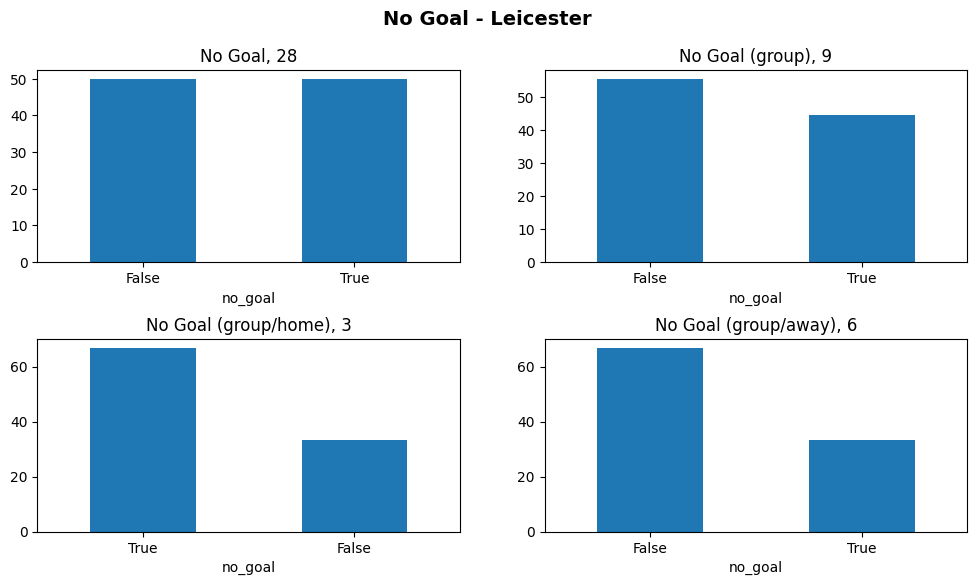

In [707]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"No Goal - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [708]:
team_home_df_grp.reset_index()\
                [['main_team','opponent_team','goal_fatti','goal_subiti','giornata','type']]\
                .sort_values('giornata')

,main_team,opponent_team,goal_fatti,goal_subiti,giornata,type
4,Leicester,Chelsea,1,2,4.0,away
0,Leicester,Crystal Palace,0,0,11.0,home
5,Leicester,Wolves,4,0,13.0,away
6,Leicester,West Ham,2,0,16.0,away
7,Leicester,Liverpool,1,2,18.0,away
2,Leicester,Fulham,0,1,19.0,home
8,Leicester,Aston Villa,4,2,22.0,away
3,Leicester,Chelsea,1,3,27.0,home
1,Leicester,Crystal Palace,1,2,29.0,away


##### N° Goals

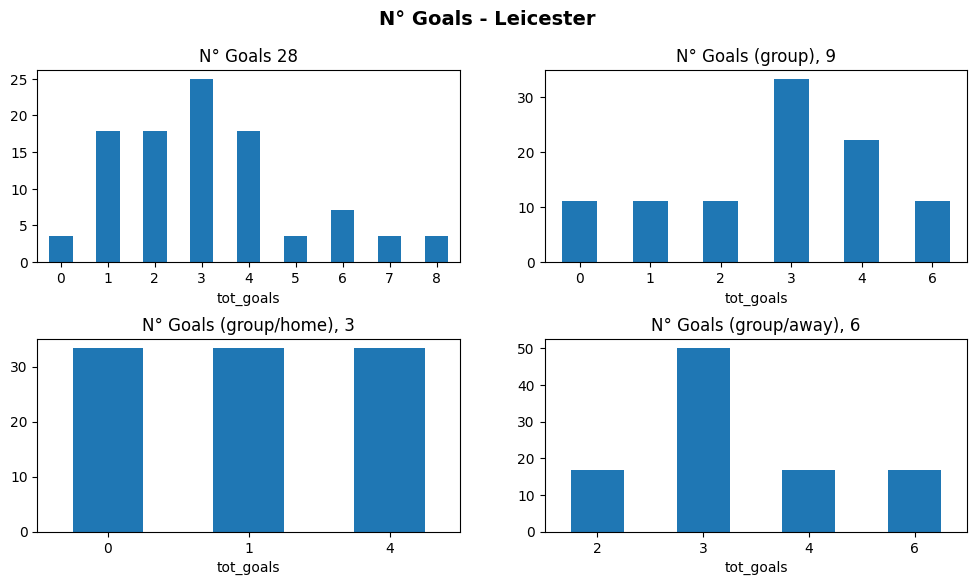

In [709]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"N° Goals - {home_team}", fontsize=14, fontweight='bold')

(team_home_df['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Has scored

<Axes: title={'center': 'Has scored (gpr/away), 6'}, xlabel='team_has_scored'>

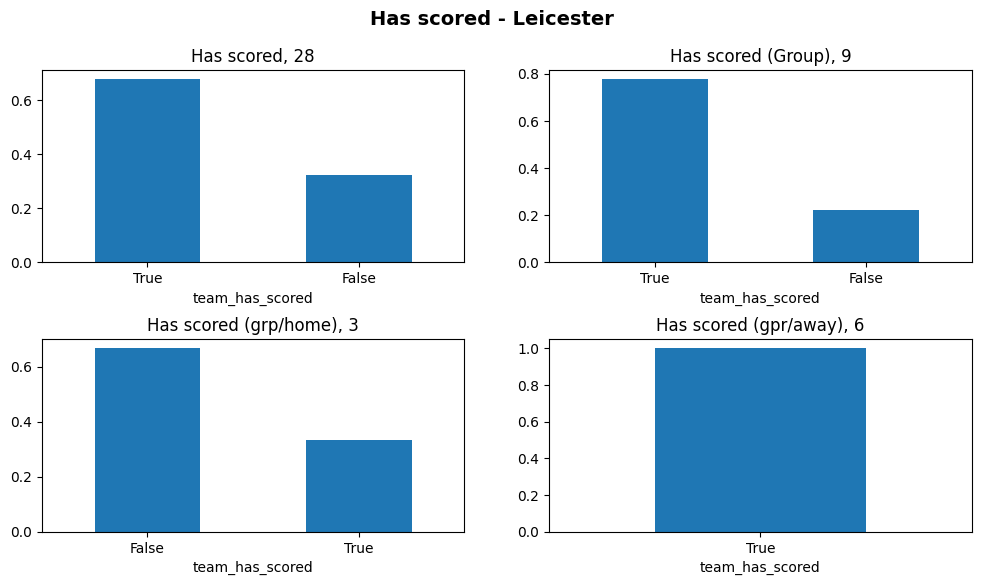

In [710]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has scored - {home_team}", fontsize=14, fontweight='bold')

team_home_df.team_has_scored.value_counts(normalize=True).plot(kind='bar', rot=0, title=f'Has scored, {len(team_home_df)}', ax=axes[0][0])
team_home_df_grp.team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (Group), {len(team_home_df_grp)}', ax=axes[0][1])
team_home_df_grp[team_home_df_grp.type=='home'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (grp/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0])
team_home_df_grp[team_home_df_grp.type=='away'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', rot=0, title=f'Has scored (gpr/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1])


In [711]:
team_home_df_grp.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
8,Leicester,Crystal Palace,0,True,False,0,0,home,Draw,False,...,"W,L,L,L,L",7,9,13,30,24,39,-15,Crystal Palace,1
9,Leicester,Crystal Palace,1,False,True,3,2,away,Loss,True,...,"W,L,L,L,L",7,9,13,30,24,39,-15,Crystal Palace,1
13,Leicester,Fulham,0,True,False,1,1,home,Loss,False,...,"L,L,L,D,W",11,6,11,39,39,39,0,Fulham,1
20,Leicester,Chelsea,1,False,True,4,3,home,Loss,True,...,"L,D,W,W,L",10,8,10,38,29,30,-1,Chelsea,1
21,Leicester,Chelsea,1,False,True,3,2,away,Loss,True,...,"L,D,W,W,L",10,8,10,38,29,30,-1,Chelsea,1


##### Has conceded goal

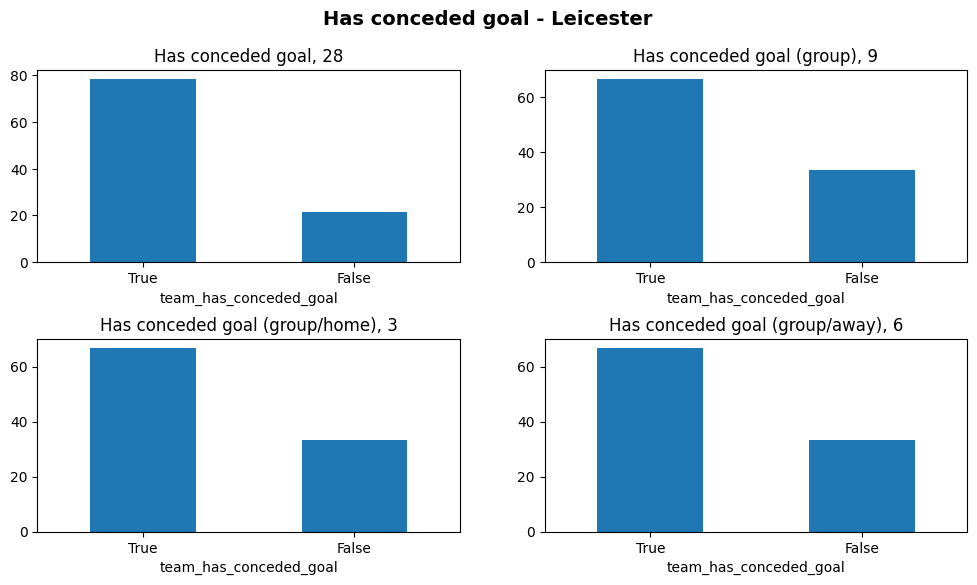

In [712]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has conceded goal - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].team_has_conceded_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Has conceded goal (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Results

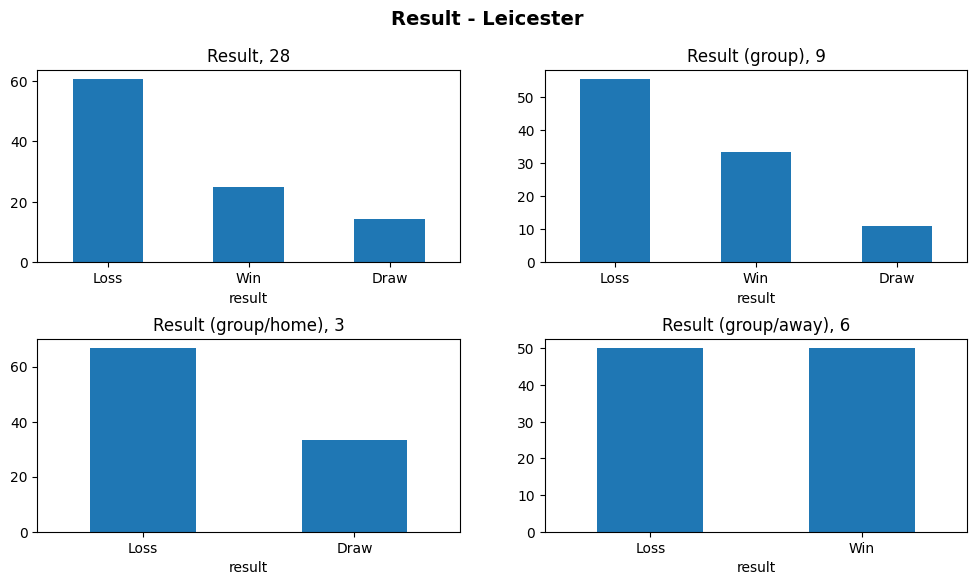

In [713]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result - {home_team}", fontsize=14, fontweight='bold')

(team_home_df.result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result, {len(team_home_df)}', ax=axes[0][0], rot=0)
(team_home_df_grp.result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group), {len(team_home_df_grp)}', ax=axes[0][1], rot=0)
(team_home_df_grp[team_home_df_grp.type=='home'].result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group/home), {len(team_home_df_grp[team_home_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_home_df_grp[team_home_df_grp.type=='away'].result.value_counts(normalize=True) * 100).plot(kind='bar', title=f'Result (group/away), {len(team_home_df_grp[team_home_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [714]:
team_home_df_grp.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
8,Leicester,Crystal Palace,0,True,False,0,0,home,Draw,False,...,"W,L,L,L,L",7,9,13,30,24,39,-15,Crystal Palace,1
9,Leicester,Crystal Palace,1,False,True,3,2,away,Loss,True,...,"W,L,L,L,L",7,9,13,30,24,39,-15,Crystal Palace,1
13,Leicester,Fulham,0,True,False,1,1,home,Loss,False,...,"L,L,L,D,W",11,6,11,39,39,39,0,Fulham,1
20,Leicester,Chelsea,1,False,True,4,3,home,Loss,True,...,"L,D,W,W,L",10,8,10,38,29,30,-1,Chelsea,1
21,Leicester,Chelsea,1,False,True,3,2,away,Loss,True,...,"L,D,W,W,L",10,8,10,38,29,30,-1,Chelsea,1


##### Result Trend

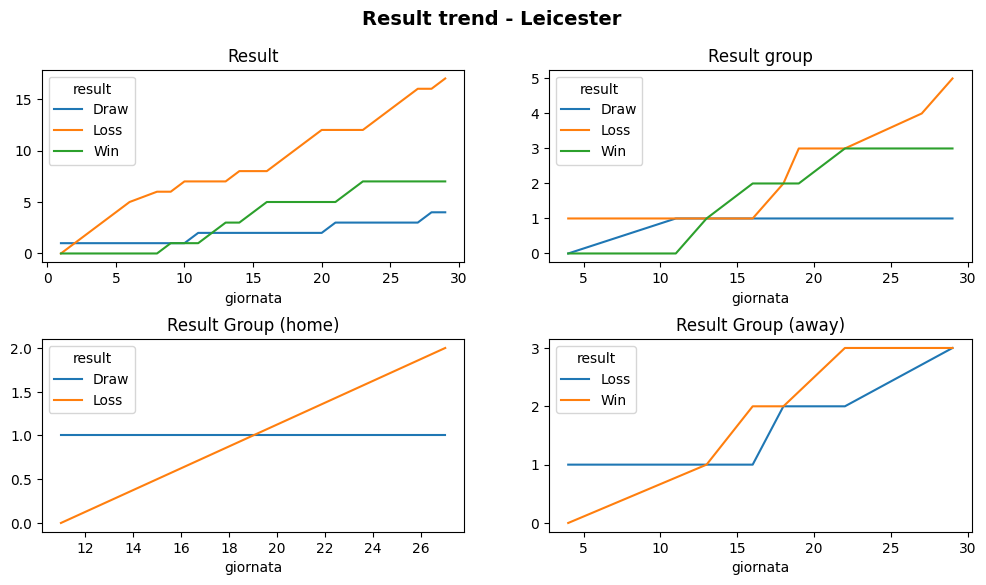

In [715]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result trend - {home_team}", fontsize=14, fontweight='bold')

team_home_df_grp['value'] = 1
team_home_df['value'] = 1
team_home_df[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result", ax=axes[0][0], rot=0)
team_home_df_grp[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result group", ax=axes[0][1], rot=0)
team_home_df_grp[team_home_df_grp.type=='home'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (home)", ax=axes[1][0], rot=0)
team_home_df_grp[team_home_df_grp.type=='away'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (away)", ax=axes[1][1], rot=0)
plt.show()

#### Away Team

In [716]:
team_away_df = df_match[(df_match.main_team==away_team)]
team_away_df.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal
10,Aston Villa,Everton,2,False,True,3,1,home,Win,True,2.0,Goal,True
37,Aston Villa,West Ham,0,True,False,1,1,home,Loss,False,4.0,No Goal,True
57,Aston Villa,Man City,1,False,True,2,1,home,Draw,True,6.0,Goal,True
66,Aston Villa,Southampton,1,True,False,1,0,home,Win,True,8.0,No Goal,False
100,Aston Villa,Chelsea,0,True,False,2,2,home,Loss,False,11.0,No Goal,True


In [717]:
team_away_df_grp = team_away_df.merge(standing, left_on='opponent_team', right_on='team_short_name')
team_away_df_grp = team_away_df_grp[team_away_df_grp.team_group == standing[standing['team_short_name']==home_team].team_group.max()]

##### Goal/No Goal

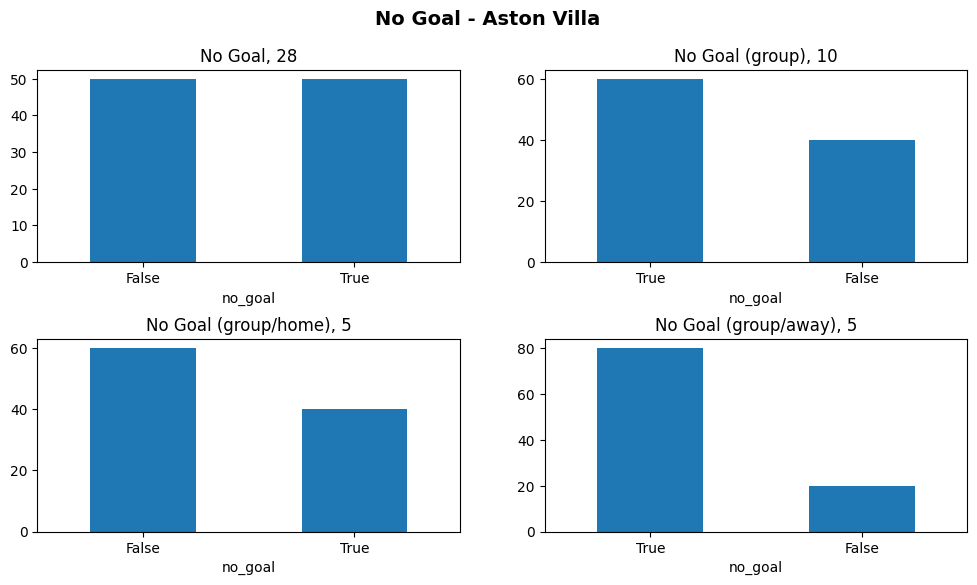

In [718]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"No Goal - {away_team}", fontsize=14, fontweight='bold')

(team_away_df.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp.no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away'].no_goal.value_counts(normalize=True) * 100).plot(kind='bar', title=f'No Goal (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

In [719]:
team_away_df.merge(standing, left_on='opponent_team', right_on='team_short_name').head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
0,Aston Villa,Everton,2,False,True,3,1,home,Win,True,...,"D,D,W,D,L",6,9,14,27,23,41,-18,Everton,2
1,Aston Villa,Everton,2,True,False,2,0,away,Win,True,...,"D,D,W,D,L",6,9,14,27,23,41,-18,Everton,2
2,Aston Villa,West Ham,0,True,False,1,1,home,Loss,False,...,"W,D,L,W,L",7,6,14,27,25,34,-9,West Ham,1
3,Aston Villa,West Ham,1,False,True,2,1,away,Draw,True,...,"W,D,L,W,L",7,6,14,27,25,34,-9,West Ham,1
4,Aston Villa,Man City,1,False,True,2,1,home,Draw,True,...,"W,W,W,W,D",20,4,4,64,71,26,45,Man City,0


##### N° Goals

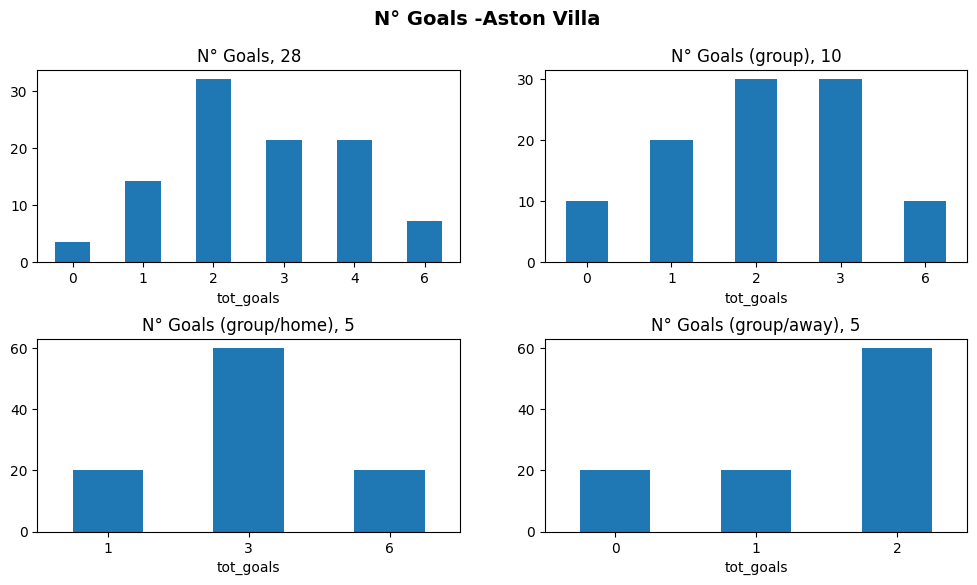

In [720]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"N° Goals -{away_team}", fontsize=14, fontweight='bold')

(team_away_df['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away']['tot_goals'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'N° Goals (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Has Scored

<Axes: title={'center': 'Has scored (grp/away), 5'}, xlabel='team_has_scored'>

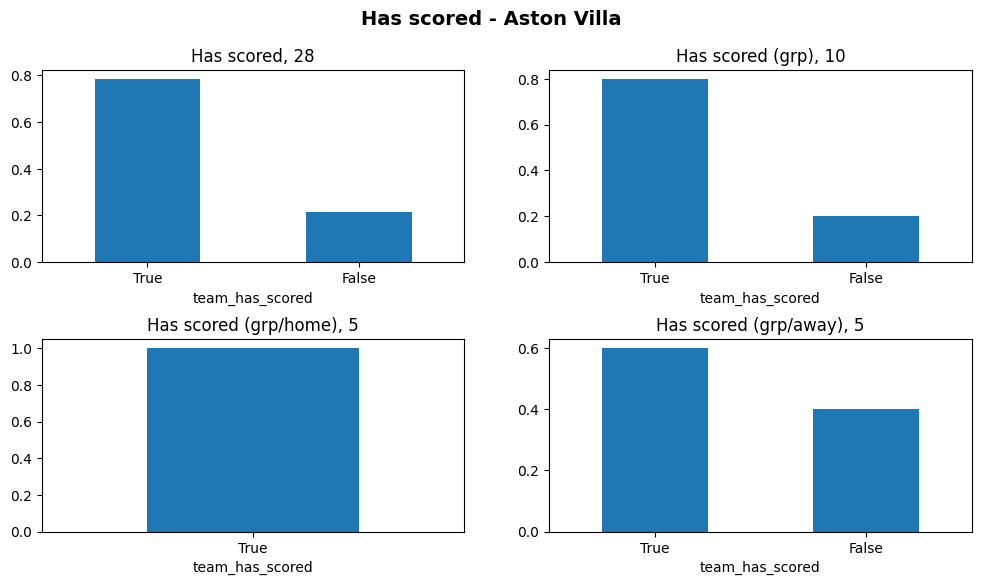

In [721]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has scored - {away_team}", fontsize=14, fontweight='bold')

team_away_df.team_has_scored.value_counts(normalize=True).plot(kind='bar', title=f'Has scored, {len(team_away_df)}', ax=axes[0][0], rot=0)
team_away_df_grp.team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'].team_has_scored.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has scored (grp/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)


##### Has Conceded Goal

<Axes: title={'center': 'Has conceded goal (grp/away), 5'}, xlabel='team_has_conceded_goal'>

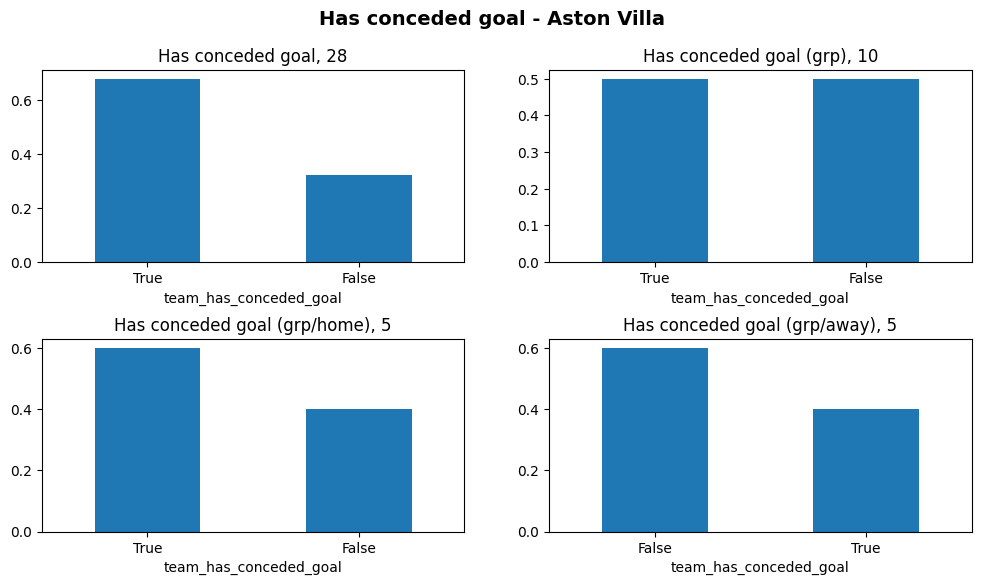

In [722]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Has conceded goal - {away_team}", fontsize=14, fontweight='bold')

team_away_df.team_has_conceded_goal.value_counts(normalize=True).plot(kind='bar', title=f'Has conceded goal, {len(team_away_df)}', ax=axes[0][0], rot=0)
team_away_df_grp.team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'].team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'].team_has_conceded_goal.value_counts(normalize=True)\
                .plot(kind='bar', title=f'Has conceded goal (grp/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)


##### Result

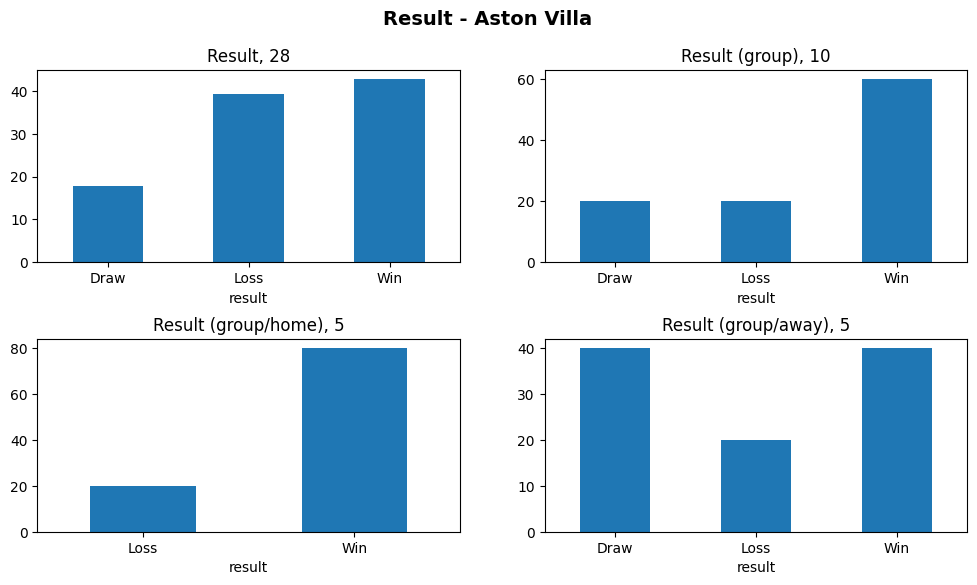

In [723]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result - {away_team}", fontsize=14, fontweight='bold')

(team_away_df['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result, {len(team_away_df)}', ax=axes[0][0], rot=0)
(team_away_df_grp['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group), {len(team_away_df_grp)}', ax=axes[0][1], rot=0)
(team_away_df_grp[team_away_df_grp.type=='home']['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group/home), {len(team_away_df_grp[team_away_df_grp.type=="home"])}', ax=axes[1][0], rot=0)
(team_away_df_grp[team_away_df_grp.type=='away']['result'].value_counts(normalize=True) * 100).sort_index().plot(kind='bar', title=f'Result (group/away), {len(team_away_df_grp[team_away_df_grp.type=="away"])}', ax=axes[1][1], rot=0)

plt.show()

##### Result Trend

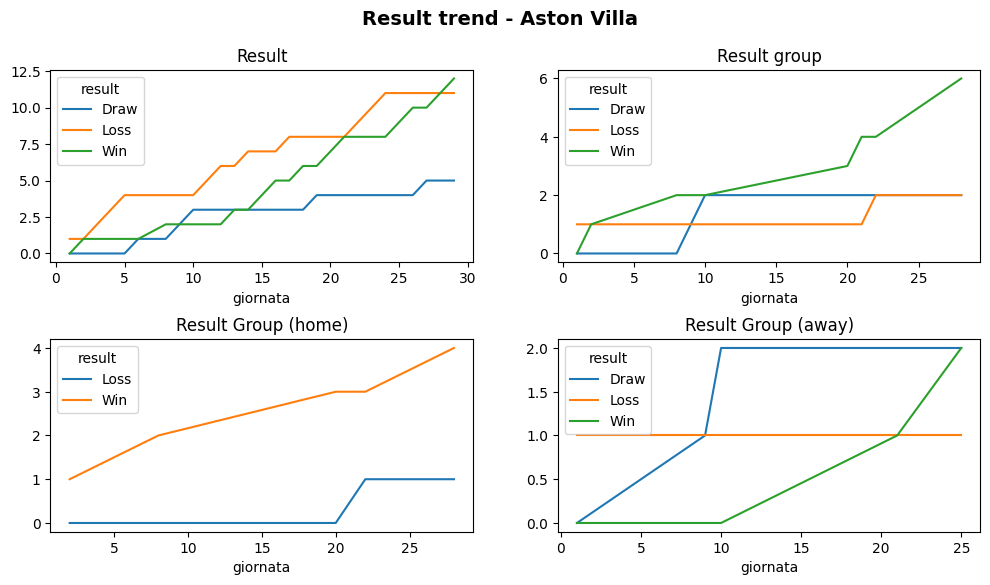

In [724]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f"Result trend - {away_team}", fontsize=14, fontweight='bold')

team_away_df_grp['value'] = 1
team_away_df['value'] = 1
team_away_df[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result", ax=axes[0][0], rot=0)
team_away_df_grp[['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result group", ax=axes[0][1], rot=0)
team_away_df_grp[team_away_df_grp.type=='home'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (home)", ax=axes[1][0], rot=0)
team_away_df_grp[team_away_df_grp.type=='away'][['giornata','result','value']]\
            .pivot(columns='result',index='giornata', values='value')\
            .fillna(0).cumsum().plot(kind='line', title=f"Result Group (away)", ax=axes[1][1], rot=0)
plt.show()

## Analysis

### Plot number goals over giornate

In [ ]:
df[['giornata','tot_goals']].groupby(['giornata']).sum().tot_goals.plot()

### Goals distribution over matches in each giornata

In [ ]:
df['row_num'] = df.groupby('giornata').cumcount()
boxgoals = df[['giornata','row_num','tot_goals']].pivot(index='row_num', columns='giornata', values='tot_goals')

In [ ]:
boxgoals.plot(kind='box', figsize=(12,4))

### Under/Over

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team', 'tot_goals']].groupby('main_team').mean().sort_values('tot_goals').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('Average goals')
ax[1].set_ylabel('Average goals')
ax[2].set_ylabel('Average goals')

plt.show()

### Goal/No Goal

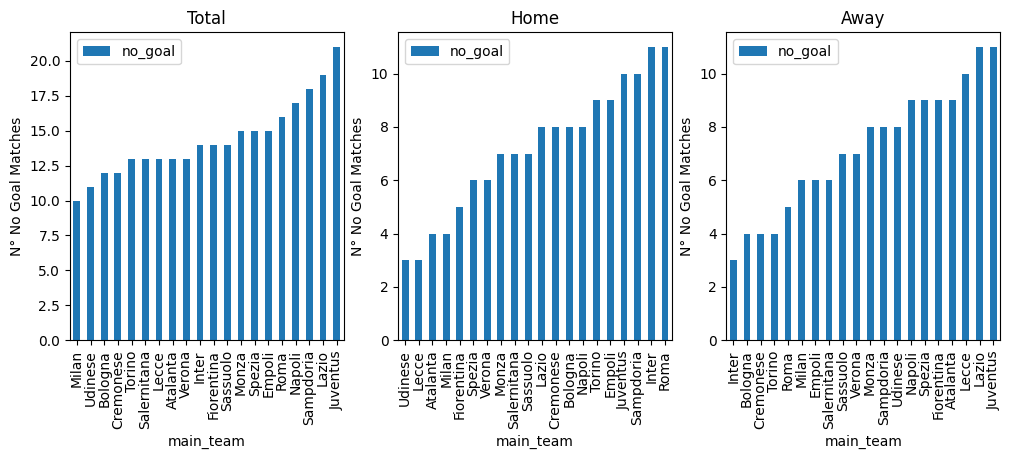

In [466]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team','no_goal']].groupby('main_team').sum().sort_values('no_goal').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('N° No Goal Matches')
ax[1].set_ylabel('N° No Goal Matches')
ax[2].set_ylabel('N° No Goal Matches')

plt.show()

In [467]:
df_match[(df_match.main_team == 'Real Madrid') & (df_match.type=='home')]

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,type,result,team_has_scored,giornata,goal_no_goal,team_has_conceded_goal


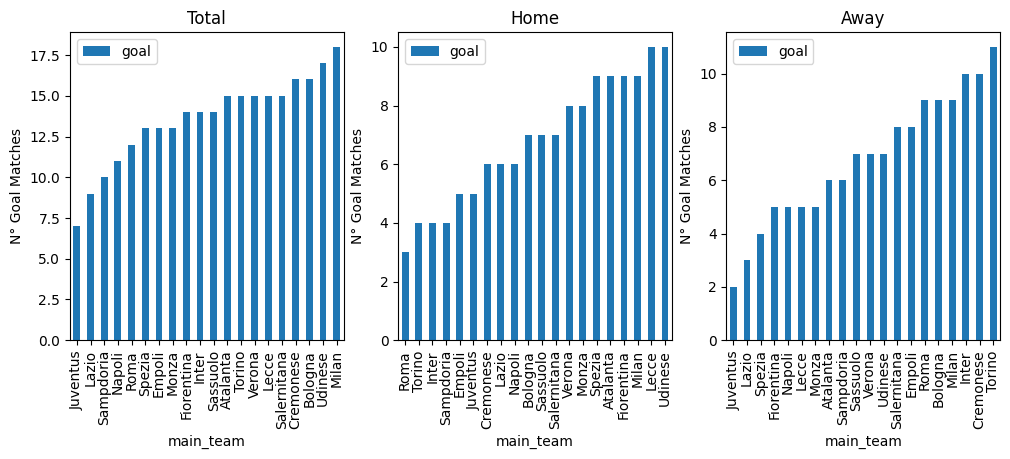

In [468]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
df_match[['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[0])
df_match[df_match.type=='home'][['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[1])
df_match[df_match.type=='away'][['main_team','goal']].groupby('main_team').sum().sort_values('goal').plot(kind='bar',  ax=ax[2])

ax[0].set_title('Total')
ax[1].set_title('Home')
ax[2].set_title('Away')
ax[0].set_ylabel('N° Goal Matches')
ax[1].set_ylabel('N° Goal Matches')
ax[2].set_ylabel('N° Goal Matches')

plt.show()